<a href="https://colab.research.google.com/github/Singhul/Projects/blob/main/Major_Project_2K23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [1]:
pip install pillow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters

In [2]:
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone **efficientnet** repo

In [3]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Singhul/efficientnet_model


/content
Cloning into 'efficientnet_model'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 191 (delta 9), reused 0 (delta 0), pack-reused 174
Receiving objects: 100% (191/191), 5.45 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [4]:
%cd efficientnet_model/

/content/efficientnet_model


## Import efficientnet and load the conv base model

In [5]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [6]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 0s 0us/step


In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"singhul","key":"f6098be28d839647b22de0caed927bf6"}'}

In [8]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 63 Apr 15 10:07 kaggle.json
/content/efficientnet_model


In [9]:
!kaggle datasets list

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                      Spotify and Youtube                              9MB  2023-03-20 15:43:25           6637        253  1.0              
erdemtaha/cancer-data                                      Cancer Data                                     49KB  2023-03-22 07:57:00           2389         63  1.0              
ulrikthygepedersen/fastfood-nutrition                      Fastfood Nutrition                              12KB  2023-03-21 10:02:41           2476         50  1.0              
lokeshparab/amazon-products-dataset                        Amazon Products Sales Dataset 2023              80M

In [10]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 97% 762M/788M [00:03<00:00, 261MB/s]
100% 788M/788M [00:03<00:00, 235MB/s]


In [11]:
!unzip -qq microsoft-catsvsdogs-dataset.zip -d dog_vs_cat

## Download and extract `dog_vs_cat` dataset

In [12]:
!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

Cat  Dog
total 408428
-rw-r--r-- 1 root root   20039 Mar 12  2020 9372.jpg
-rw-r--r-- 1 root root   23514 Mar 12  2020 9373.jpg
-rw-r--r-- 1 root root    5367 Mar 12  2020 9374.jpg
-rw-r--r-- 1 root root   54616 Mar 12  2020 9375.jpg
-rw-r--r-- 1 root root   26728 Mar 12  2020 9376.jpg
-rw-r--r-- 1 root root   24099 Mar 12  2020 9377.jpg
-rw-r--r-- 1 root root   41794 Mar 12  2020 9378.jpg
-rw-r--r-- 1 root root   26466 Mar 12  2020 9379.jpg
-rw-r--r-- 1 root root   30844 Mar 12  2020 9380.jpg


In [13]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12500


In [14]:


# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [15]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [19]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
history = model.fit(
     train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
41/41 [==============================] - 31s 579ms/step - loss: 0.4475 - acc: 0.8279 - val_loss: 0.2626 - val_acc: 0.9083
Epoch 2/20
41/41 [==============================] - 22s 505ms/step - loss: 0.3465 - acc: 0.8562 - val_loss: 0.2469 - val_acc: 0.9271
Epoch 3/20
41/41 [==============================] - 21s 489ms/step - loss: 0.3478 - acc: 0.8663 - val_loss: 0.2469 - val_acc: 0.9281
Epoch 4/20
41/41 [==============================] - 17s 392ms/step - loss: 0.3423 - acc: 0.8632 - val_loss: 0.2277 - val_acc: 0.9344
Epoch 5/20
41/41 [==============================] - 23s 499ms/step - loss: 0.3241 - acc: 0.8678 - val_loss: 0.2433 - val_acc: 0.9281
Epoch 6/20
41/41 [==============================] - 18s 395ms/step - loss: 0.3229 - acc: 0.8653 - val_loss: 0.2401 - val_acc: 0.9302
Epoch 7/20
41/41 [==============================] - 25s 529ms/step - loss: 0.3257 - acc: 0.8694 - val_loss: 0.2248 - val_acc: 0.9323
Epoch 8/20
41/41 [==============================] - 21s 498ms/step - 

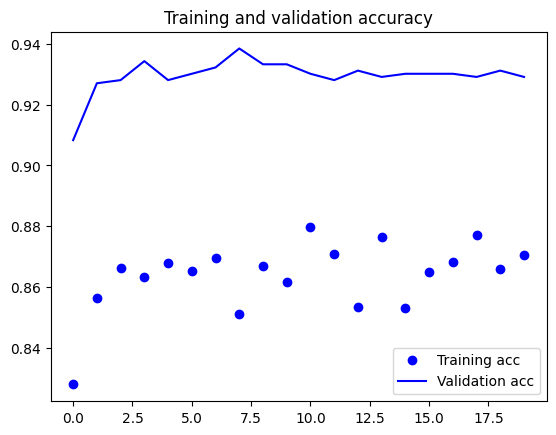

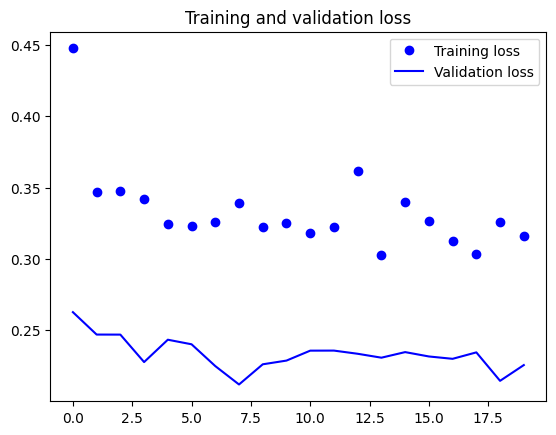

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [36]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-37-4287107a2cee>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
41/41 [==============================] - 31s 507ms/step - loss: 0.4508 - acc: 0.8350 - val_loss: 0.3931 - val_acc: 0.8938
Epoch 2/20
41/41 [==============================] - 24s 557ms/step - loss: 0.3867 - acc: 0.8463 - val_loss: 0.2614 - val_acc: 0.9229
Epoch 3/20
41/41 [==============================] - 22s 499ms/step - loss: 0.4087 - acc: 0.8345 - val_loss: 0.2259 - val_acc: 0.9260
Epoch 4/20
41/41 [==============================] - 23s 536ms/step - loss: 0.3831 - acc: 0.8519 - val_loss: 0.4511 - val_acc: 0.8771
Epoch 5/20
41/41 [==============================] - 16s 368ms/step - loss: 0.4040 - acc: 0.8489 - val_loss: 0.4824 - val_acc: 0.8667
Epoch 6/20
41/41 [==============================] - 23s 547ms/step - loss: 0.4388 - acc: 0.8407 - val_loss: 0.2757 - val_acc: 0.9073
Epoch 7/20
41/41 [==============================] - 17s 394ms/step - loss: 0.3566 - acc: 0.8525 - val_loss: 0.2759 - val_acc: 0.9115
Epoch 8/20
41/41 [==============================] - 17s 398ms/step - 

In [38]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

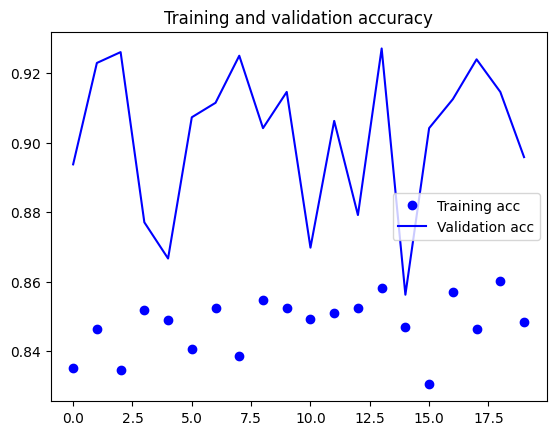

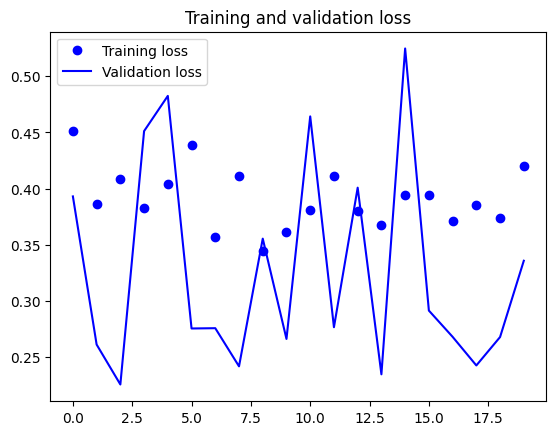

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [31]:
cat_img = cat_images[3]
dog_img= dog_images[3]

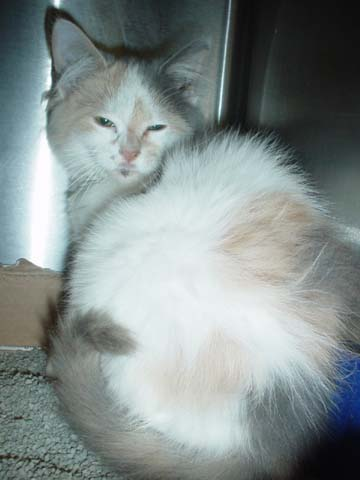

In [29]:
Image(filename=cat_img)

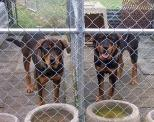

In [32]:
Image(filename=dog_img)

In [33]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

1/1 [==============================] - 0s 26ms/step
('cat', 0.99737895)
1/1 [==============================] - 0s 25ms/step
('dog', 0.965697206556797)


## Download the model

In [40]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [42]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [43]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")